<a href="https://colab.research.google.com/github/lakshrav/Deep_Learning_Project/blob/main/Music_genre_and_speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music and Deep Learning: Music Generation using LSTMs, Music Genre Classification using Transfer Learning and an Investigation of the Acoustic Similarity between Music and Speech

CS6005 Deep Learning <br>

Submitted by <br>

Rithvik Senthil (2020103039) <br>
Abirami G (2020103502, Batch : Q) <br>
Lakshana (2020103537, Batch : Q)


# A. Music Genre Classification

# 1. Installing Dependencies and Setup

In [2]:
!pip install livelossplot

In [63]:
import random, os, glob # default python modules that let me randomise and manipulate files
import numpy as np # for data manipulation through arrays
import tensorflow as tf
from keras.models import Sequential # the model we will use
from keras.layers import Dropout, Dense, Conv2D, MaxPool2D, Flatten, Reshape, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping # for better training
from tensorflow.keras.applications import VGG19 # transfer learning model
from keras import backend
from livelossplot import PlotLossesKeras # to visualy display how my model improves as training progresses
import librosa # to demonstrate the creation of a mel spectrogram
from librosa.display import specshow
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import pandas as pd
import random
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
from IPython.core.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")
from scipy.ndimage import zoom
import cv2
from sklearn.model_selection import train_test_split


In [4]:
# utility function to initialise a random seed
def setRandom():
    seed = 0 # random seed value
    os.environ["PYTHONHASHSEED"] = str(seed) # if this is not set, a random value is used to seed the hashes of some objects
    random.seed(seed) # sets the base python and numpy random seeds
    np.random.seed(seed)
    tf.random.set_seed(seed) # sets the tensorflow random seed
    tf.compat.v1.set_random_seed(seed)

In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 2. Sampling the Data

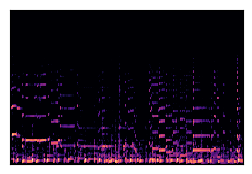

In [5]:
filePath = "gdrive/MyDrive/DL Project/Datasets/Genre/genres_original/jazz/jazz.00099.wav" # an example file

#librosa is a python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems.
file, samplingRate = librosa.load(filePath)
example, _ = librosa.effects.trim(file)

hopLength = 512 # the number of samples between successive columns of the spectrogram

spectrogram = librosa.power_to_db(librosa.feature.melspectrogram(y = example, sr = samplingRate, n_fft = 2048, hop_length = hopLength, n_mels = 128, power = 4.0), ref = np.max)

plt.figure(figsize = (3, 2))
librosa.display.specshow(spectrogram, sr = samplingRate, hop_length = hopLength, x_axis = "off", y_axis = "off")
ipd.Audio(example, rate = samplingRate)

# 3. Preprocessing the Data

1. Removing Erroneous Values

In [6]:
source = "gdrive/MyDrive/DL Project/Datasets/Genre/images_original/" # source folder path
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"] # list with the genre folder names

for genre in genres: # iterate through each genre folder
    path = os.path.join(source, genre)
    pngs = [i for i in os.listdir(path) if i[-4:] == ".png"] # get a list of .png files in the genre folder
    print(f"Size of {genre} dataset: {len(pngs)} files.")

Size of blues dataset: 100 files.
Size of classical dataset: 100 files.
Size of country dataset: 100 files.
Size of disco dataset: 100 files.
Size of hiphop dataset: 100 files.
Size of jazz dataset: 99 files.
Size of metal dataset: 100 files.
Size of pop dataset: 100 files.
Size of reggae dataset: 100 files.
Size of rock dataset: 100 files.


2. Splitting the Dataset

In [7]:
split = [80, 9, 10]
train, val, test = {}, {}, {} # empty dictionaries to store the filepaths
trainLen, valLen, testLen = {}, {}, {} # empty dictionaries to store the number of files under each genre for each dataset
dictionaries = [train, val, test]

for d in dictionaries:
    if d == train: num = slice(0, split[0])
    elif d == val: num = slice(split[0], split[0] + split[1])
    else: num = slice(split[0] + split[1], split[0] + split[1] + split[2])
    for genre in genres: # iterate through each genre folder
        path = os.path.join(source, genre)
        pngs = glob.glob(os.path.join(path, "*.png")) # get a list of .png filepaths in the genre folder
        selected = pngs[num] # take the first 80 files
        d[genre] = selected # store the selected files in the dictionary

lenDictionaries = [{genre: len(d[genre]) for genre in genres} for d in dictionaries]

print(f"\033[1mTraining:\033[0m {lenDictionaries[0]}")
print(f"\033[1mValidation:\033[0m {lenDictionaries[1]}")
print(f"\033[1mTest:\033[0m {lenDictionaries[2]}")

Training: {'blues': 80, 'classical': 80, 'country': 80, 'disco': 80, 'hiphop': 80, 'jazz': 80, 'metal': 80, 'pop': 80, 'reggae': 80, 'rock': 80}
Validation: {'blues': 9, 'classical': 9, 'country': 9, 'disco': 9, 'hiphop': 9, 'jazz': 9, 'metal': 9, 'pop': 9, 'reggae': 9, 'rock': 9}
Test: {'blues': 10, 'classical': 10, 'country': 10, 'disco': 10, 'hiphop': 10, 'jazz': 10, 'metal': 10, 'pop': 10, 'reggae': 10, 'rock': 10}


3. Data Formatting

In [8]:
batchSize = 32 # typical batch size for a neural network
genreMap = {
    "blues": 0,
    "classical": 1,
    "country": 2,
    "disco": 3,
    "hiphop": 4,
    "jazz": 5,
    "metal": 6,
    "pop": 7,
    "reggae": 8,
    "rock": 9
}
inverseGenreMap = {value: key for key, value in genreMap.items()}

def createDataset(d):
    imgSize = (288, 432) # define image and batch parameters
    imageList, labelList = [], [] # create lists to store images and labels

    for genre, paths in d.items():
        for path in paths:
            image = tf.cast(tf.image.resize(tf.image.decode_png(tf.io.read_file(path), channels = 3), imgSize), tf.float32) / 255.0 # normalise pixel values between 0 and 1 (preprocessing!)
            imageList.append(image)
            labelList.append(genreMap[genre]) # convert genre to its integer label

    dataset = tf.data.Dataset.from_tensor_slices((imageList, labelList)).shuffle(buffer_size=len(imageList)).batch(batchSize) # create and return tensorflow dataset
    return(dataset)

def prep(ds):
    out = (
        ds.map(lambda image, label: (tf.image.convert_image_dtype(image, tf.float32), label)) # modifies the image tensor's data type to floats
        .cache() # cache dataset elements in memory or on disk to speed up data loading
        .prefetch(buffer_size = tf.data.experimental.AUTOTUNE) # prefetch dataset elements in the background and automatically optimise data loading
    )
    return out # return the prepared and optimised dataset

training, validation, testing = prep(createDataset(train)), prep(createDataset(val)), prep(createDataset(test))
print("Datasets created.") # to let me know when it's finished running (:

Datasets created.


Training Examples:


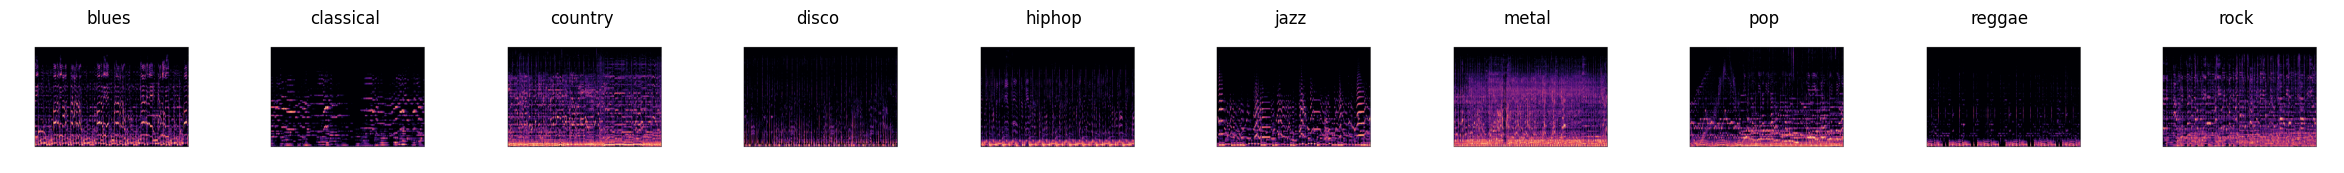

Validation Examples:


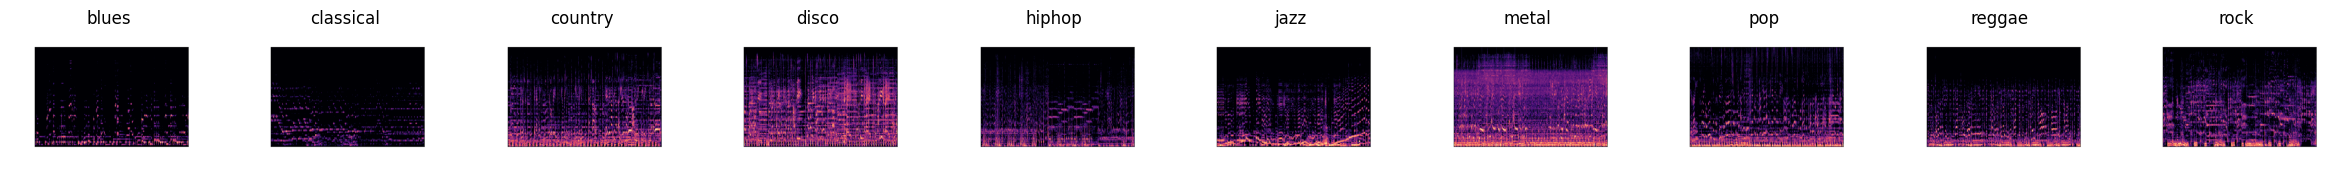

Testing Examples:


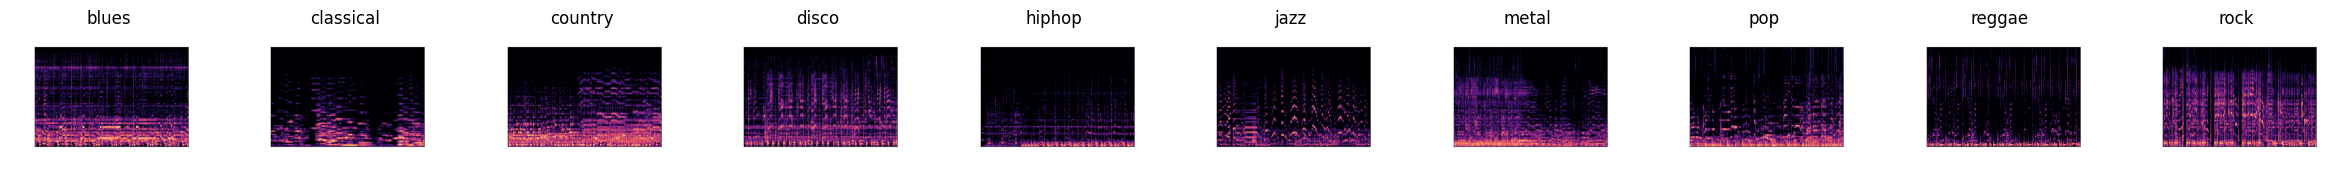

In [9]:
def view_dataset(dataset):
    genreExamples = {}  # dictionary to store examples for each label

    for images, labels in dataset:
        for image, label in zip(images, labels):
            label = int(label.numpy())  # convert label tensor to integer
            if label not in genreExamples:
                genreExamples[label] = image

        if len(genreExamples) == len(genres):
            break

    # display the randomly chosen examples
    plt.figure(figsize = (30, 20))
    for label, image in genreExamples.items():
        ax = plt.subplot(1, len(genres), label + 1)
        plt.imshow(image)
        plt.title(inverseGenreMap[label])
        plt.axis("off")
    plt.show()

print("\033[1mTraining Examples:\033[0m"); view_dataset(training) # shows a labelled example of a mel spectrogram from each genre from each dataset
print("\033[1mValidation Examples:\033[0m"); view_dataset(validation)
print("\033[1mTesting Examples:\033[0m"); view_dataset(testing)

# 4. Choosing and Training a Model

1. Transfer Learning Model using Inceptionv3 architecture

In [10]:
inputShape = [288, 432, 3] # the shape of the images (288px tall, 432px wide, and 3 colour channels/RGB)

earlyStopping = EarlyStopping( # a custom early stopping setup to automatically stop training when loss doesn't increase enough after a number of epochs
    min_delta = 0.001, # minimium amount of change to count as an improvement
    patience = 20, # how many epochs to wait before stopping
    restore_best_weights = True # tells it to restore back to when loss was at its lowest value
)

In [11]:
from tensorflow.keras.applications import InceptionV3 # transfer learning model
baseModel = InceptionV3(input_shape = inputShape, weights = "imagenet", include_top = False, pooling = "avg")

for layer in baseModel.layers:
    layer.trainable = False # freeze the pre-trained layers

transfer = Sequential([
    baseModel,

    Flatten(),
    BatchNormalization(),
    Dense(512, activation = "relu"),
    Dropout(0.3),
    Dense(256, activation = "relu"),
    Dropout(0.3), # dropout layer to prevent overfitting
    Dense(128, activation = "relu"),
    Dropout(0.3),
    Dense(len(genres), activation = "softmax")
])

transfer.compile(optimizer = tf.keras.optimizers.SGD(lr = 0.0001), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
transfer.summary()

87910968/87910968 [==============================] - 1s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

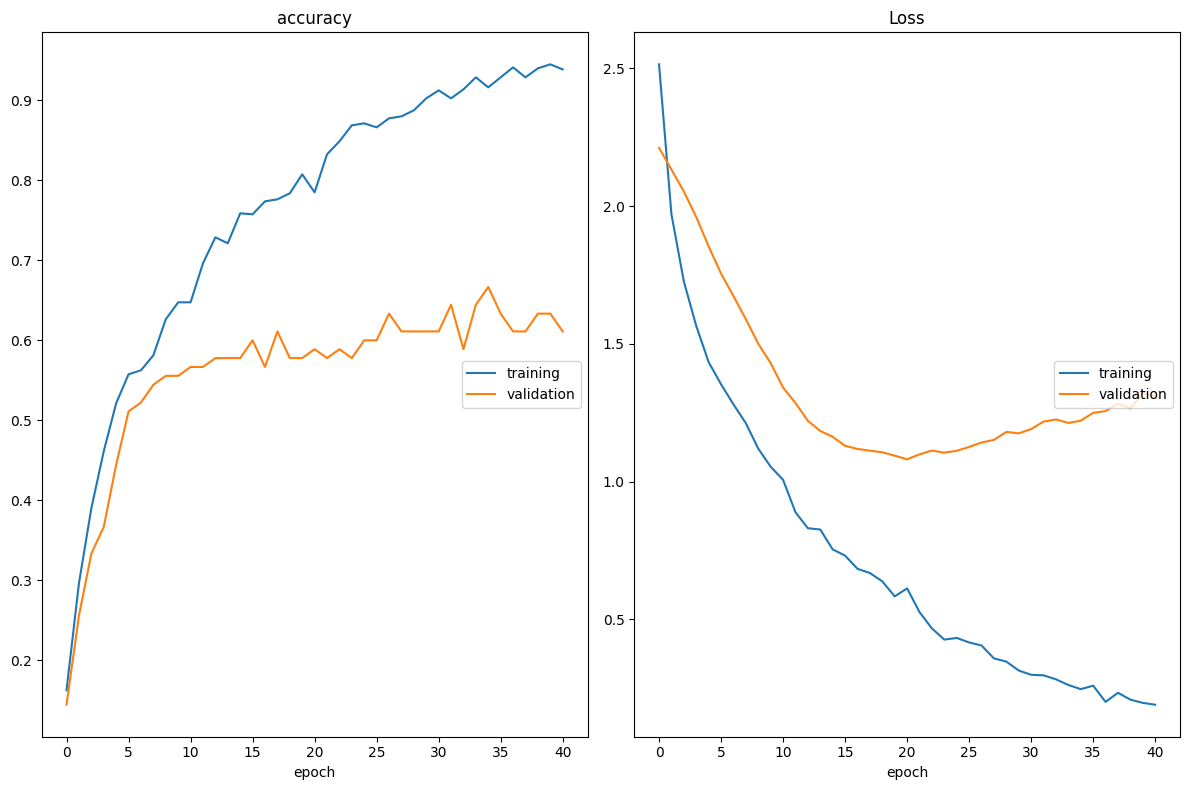

accuracy
	training         	 (min:    0.162, max:    0.945, cur:    0.939)
	validation       	 (min:    0.144, max:    0.667, cur:    0.611)
Loss
	training         	 (min:    0.190, max:    2.515, cur:    0.190)
	validation       	 (min:    1.081, max:    2.212, cur:    1.311)
25/25 [==============================] - 6s 224ms/step - loss: 0.1897 - accuracy: 0.9388 - val_loss: 1.3110 - val_accuracy: 0.6111


In [12]:
setRandom()
transferHistory = transfer.fit(training, validation_data = validation, batch_size = batchSize, epochs = 500, verbose = 1, callbacks = [earlyStopping, PlotLossesKeras()])

2. Custom CNN architecture

In [13]:
cnn = Sequential([
    BatchNormalization(input_shape = inputShape),

    Conv2D(32, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),

    Conv2D(64, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),

    Conv2D(128, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),

    Conv2D(256, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),

    Conv2D(512, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),

    Flatten(),
    Dense(1024, activation = "relu"),
    Dropout(0.5),
    Dense(512, activation = "relu"),
    Dropout(0.5),
    BatchNormalization(),
    Dense(len(genres), activation = "softmax")
])

cnn.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"]) # "sparse_categorical_crossentropy" because labels are integers
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_95 (Ba  (None, 288, 432, 3)       12        
 tchNormalization)                                               
                                                                 
 conv2d_94 (Conv2D)          (None, 286, 430, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 143, 215, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_95 (Conv2D)          (None, 141, 213, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 70, 106, 64)       0         
 g2D)                                                            
                                                      

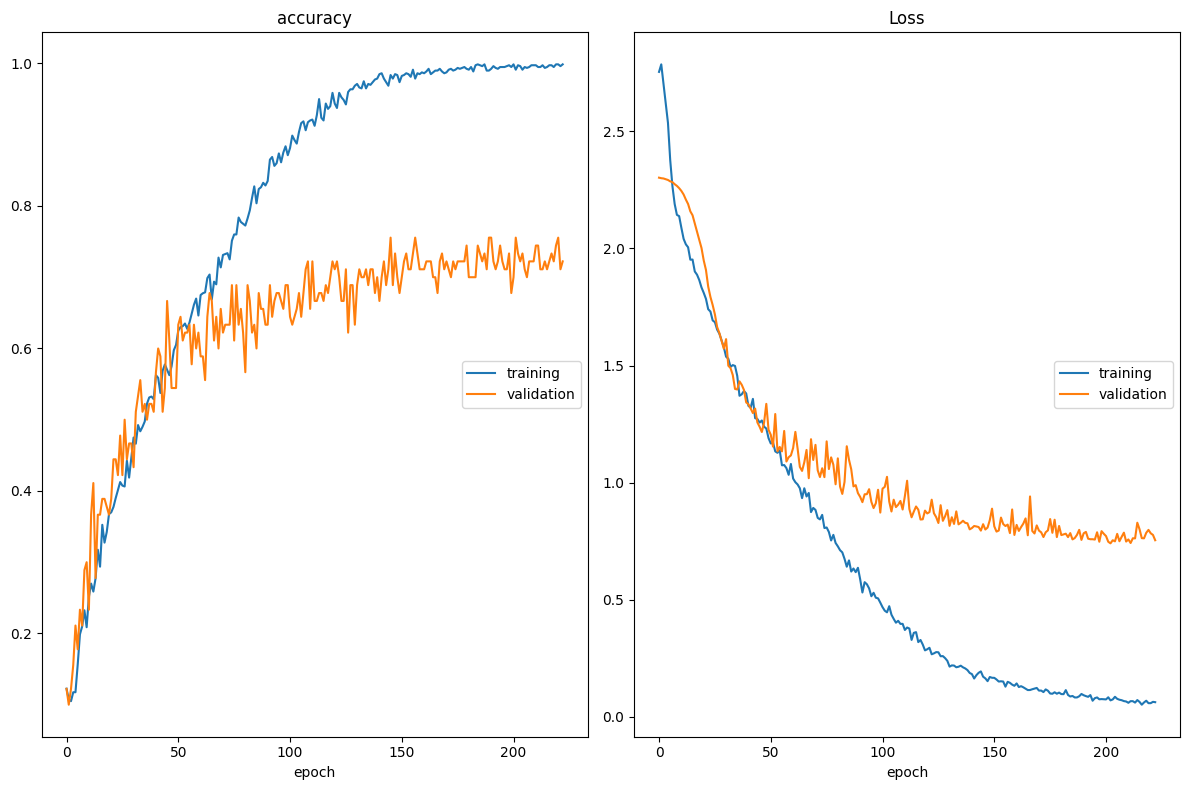

accuracy
	training         	 (min:    0.105, max:    0.999, cur:    0.999)
	validation       	 (min:    0.100, max:    0.756, cur:    0.722)
Loss
	training         	 (min:    0.051, max:    2.786, cur:    0.062)
	validation       	 (min:    0.740, max:    2.302, cur:    0.754)
25/25 [==============================] - 5s 198ms/step - loss: 0.0619 - accuracy: 0.9987 - val_loss: 0.7536 - val_accuracy: 0.7222


In [15]:
setRandom()
cnn.fit(training, validation_data = validation, batch_size = batchSize, epochs = 500, verbose = 1, callbacks = [earlyStopping, PlotLossesKeras()])

# 5. Test Data Report and Confusion Matrix

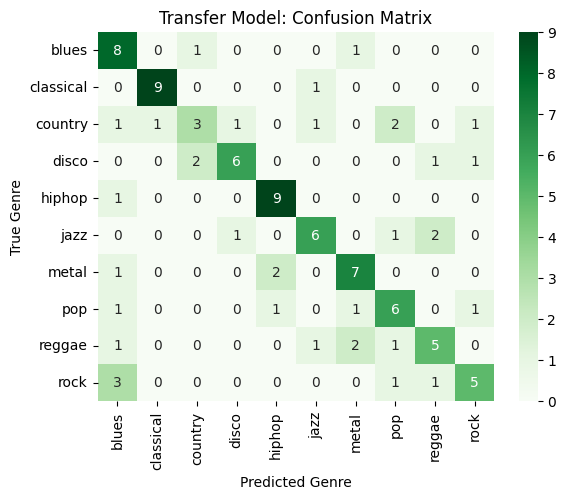

Transfer Model
Training Accuracy: 94.5% 
Train Loss: 0.3027

Validation Accuracy: 58.8889% 
Test Loss: 1.0805

Testing Accuracy: 64.0% 
Test Loss: 1.1446


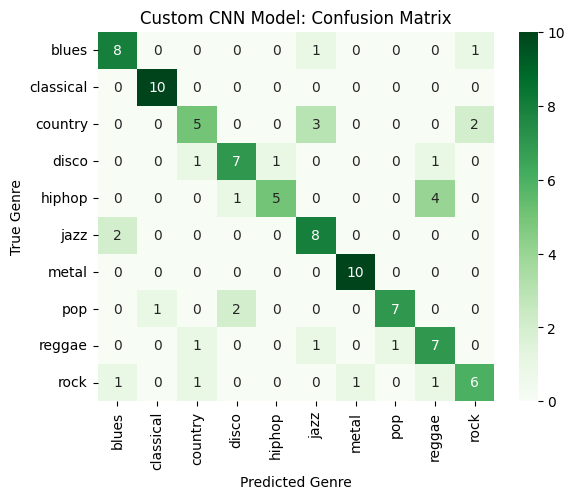

Custom CNN Model
Training Accuracy: 99.875% 
Train Loss: 0.0132

Validation Accuracy: 73.3333% 
Test Loss: 0.7405

Testing Accuracy: 73.0% 
Test Loss: 0.8548


In [16]:
def confusionMatrix(model, name):
    trueLabels = np.concatenate([y for x, y in testing], axis = 0) # get the true labels from the testing dataset

    predictedLabels = np.argmax(model.predict(testing, verbose = 0), axis = 1) # get the predicted labels from the model

    matrix = confusion_matrix(trueLabels, predictedLabels) # create the confusion matrix

    plt.figure() # plot the confusion matrix using seaborn for the heatmap
    sns.heatmap(matrix, annot = True, cmap = "Greens", xticklabels = genres, yticklabels = genres)
    plt.xlabel("Predicted Genre")
    plt.ylabel("True Genre")
    plt.title(f"{name} Model: Confusion Matrix")
    plt.show()

    trainStats, valStats, testStats = model.evaluate(training, verbose = 0), model.evaluate(validation, verbose = 0), model.evaluate(testing, verbose = 0)
    print(f"\033[1m{name} Model\033[0m")
    print(f"Training Accuracy: {round(trainStats[1] * 100, 4)}% \nTrain Loss: {round(trainStats[0], 4)}\n")
    print(f"Validation Accuracy: {round(valStats[1] * 100, 4)}% \nTest Loss: {round(valStats[0], 4)}\n")
    print(f"Testing Accuracy: {round(testStats[1] * 100, 4)}% \nTest Loss: {round(testStats[0], 4)}")

confusionMatrix(transfer, "Transfer")
confusionMatrix(cnn, "Custom CNN")

# 6. Sample Prediction

In [17]:
setRandom()
genre, paths = random.choice(list(test.items())) # chooses a random genre and corresponding list of paths
path = paths[random.randint(0, len(paths) - 1)] # chooses a random path within that list
soundPath = f"{path[:-4]}.wav".replace("images_original", "genres_original") # creates a new variable for the image path's respective audio file path
soundPath = soundPath[:-9] + "." + soundPath[-9:]

image = tf.image.decode_png(tf.io.read_file(path), channels = 3)
image = tf.image.resize(image, inputShape[:2])  # resize the image to the input shape of the model
image = tf.cast(image, tf.float32) / 255.0 # normalise pixel values
image = np.expand_dims(image, axis = 0) # expand dimensions to match the batch size (even though it's just one image)

predictions = cnn.predict(image) # make a prediction using the custom cnn model
predictedGenre = inverseGenreMap[np.argmax(predictions)] # get the predicted class label

print(f"\033[1mPredicted genre:\033[0m {predictedGenre}")
print(f"\033[1mActual genre:\033[0m {genre}")
print(f"\033[1mFilepath:\033[0m {soundPath[71:]}")
ipd.Audio(soundPath)

1/1 [==============================] - 0s 392ms/step
Predicted genre: metal
Actual genre: metal
Filepath: 077.wav


# B. Investigating the similarity of acoustic features between speech and text by finetuning on speech dataset for speech emotion recognition

# 1. Saving and Loading the Custom CNN models (Gave Better performance in the base task)

In [ ]:
cnn.save('/content/drive/MyDrive/CEG/Semester 7/DL_project/DL Project/Models/cnn', save_format="h5")

In [6]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/DL_project/DL Project/Models/cnn')
model.pop()
for layer in model.layers:
    layer.trainable = False # FREEZE the pre-trained layers (IMPORTANT!!!)

In [7]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_97 (Ba  (None, 288, 432, 3)       12        
 tchNormalization)                                               
                                                                 
 conv2d_99 (Conv2D)          (None, 286, 430, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 143, 215, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_100 (Conv2D)         (None, 141, 213, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 70, 106, 64)       0         
 ng2D)                                                           
                                                      

# 2. Adding Fully Connected layers for fine tuning

In [8]:
newModel = Sequential([
    model,
    Flatten(),
    BatchNormalization(),
    Dense(512, activation = "relu"),
    Dropout(0.3),
    Dense(256, activation = "relu"),
    Dropout(0.3), # dropout layer to prevent overfitting
    Dense(128, activation = "relu"),
    Dropout(0.3),
    Dense(7, activation = "softmax")
])

In [9]:
newModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 512)               42466636  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

# 3. Loading Speech Dataset

In [29]:
# Refer to preprocessing.ipynb for preprocesing script to obtain dataset.csv
df = pd.read_csv(f"/content/gdrive/MyDrive/DL_project/dataset.csv")

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7328 entries, 0 to 7327
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7328 non-null   int64  
 1   path        7328 non-null   object 
 2   duration    7328 non-null   float64
 3   dataset     7328 non-null   object 
 4   emotion     7328 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 286.4+ KB


In [31]:
len(df)

7328

# 4. Preprocessing Dataset (Taking a subset of existing data)

In [32]:
df_final = pd.DataFrame()

In [33]:
df['emotion'].unique()

array(['sad', 'surprise', 'neutral', 'happy', 'fear', 'disgust', 'angry'],
      dtype=object)

In [34]:
final_df = pd.DataFrame()

# List of unique datasets and emotions
unique_datasets = df['dataset'].unique()
unique_emotions = df['emotion'].unique()

# Number of rows to select for each emotion and dataset
rows_per_emotion_per_dataset = 80

# Iterate through each dataset and emotion to select rows
for dataset in unique_datasets:
    for emotion in unique_emotions:
        # Select rows that match the current dataset and emotion
        subset = df[(df['dataset'] == dataset) & (df['emotion'] == emotion)]

        # Take the first 100 rows (or less if there are fewer rows)
        subset = subset.head(rows_per_emotion_per_dataset)

        # Append the selected subset to the new DataFrame
        final_df = final_df.append(subset, ignore_index=True)

# Display the resulting DataFrame
print(final_df)

      Unnamed: 0                                               path  duration  \
0              0  /content/gdrive/MyDrive/DL_project/TESS/YAF_sa...     1.942   
1              1  /content/gdrive/MyDrive/DL_project/TESS/YAF_sa...     2.192   
2              2  /content/gdrive/MyDrive/DL_project/TESS/YAF_sa...     2.080   
3              3  /content/gdrive/MyDrive/DL_project/TESS/YAF_sa...     2.036   
4              4  /content/gdrive/MyDrive/DL_project/TESS/YAF_sa...     2.206   
...          ...                                                ...       ...   
1555        7257  /content/gdrive/MyDrive/DL_project/SAVEE/Audio...     2.657   
1556        7259  /content/gdrive/MyDrive/DL_project/SAVEE/Audio...     4.025   
1557        7260  /content/gdrive/MyDrive/DL_project/SAVEE/Audio...     4.604   
1558        7262  /content/gdrive/MyDrive/DL_project/SAVEE/Audio...     3.315   
1559        7263  /content/gdrive/MyDrive/DL_project/SAVEE/Audio...     3.473   

     dataset emotion  
0   

In [35]:
final_df.shape

(1560, 5)

In [36]:
final_df.head(1800)

Unnamed: 0                                               path  duration  \
0              0  /content/gdrive/MyDrive/DL_project/TESS/YAF_sa...     1.942   
1              1  /content/gdrive/MyDrive/DL_project/TESS/YAF_sa...     2.192   
2              2  /content/gdrive/MyDrive/DL_project/TESS/YAF_sa...     2.080   
3              3  /content/gdrive/MyDrive/DL_project/TESS/YAF_sa...     2.036   
4              4  /content/gdrive/MyDrive/DL_project/TESS/YAF_sa...     2.206   
...          ...                                                ...       ...   
1555        7257  /content/gdrive/MyDrive/DL_project/SAVEE/Audio...     2.657   
1556        7259  /content/gdrive/MyDrive/DL_project/SAVEE/Audio...     4.025   
1557        7260  /content/gdrive/MyDrive/DL_project/SAVEE/Audio...     4.604   
1558        7262  /content/gdrive/MyDrive/DL_project/SAVEE/Audio...     3.315   
1559        7263  /content/gdrive/MyDrive/DL_project/SAVEE/Audio...     3.473   

     dataset emotion  
0       TESS     sad  
1       TESS     sad  
2       TESS     sad  
3       TESS     sad  
4       TESS     sad  
...      ...     ...  
1555   SAVEE   angry  
1556   SAVEE   angry  
1557   SAVEE   angry  
1558   SAVEE   angry  
1559   SAVEE   angry  

[1560 rows x 5 columns]

In [ ]:
final_df.to_csv(f"/content/gdrive/MyDrive/CEG/Semester 7/DL_project/dataset_final.csv")

In [37]:
df = final_df

# 4. Viewing dataset distribution

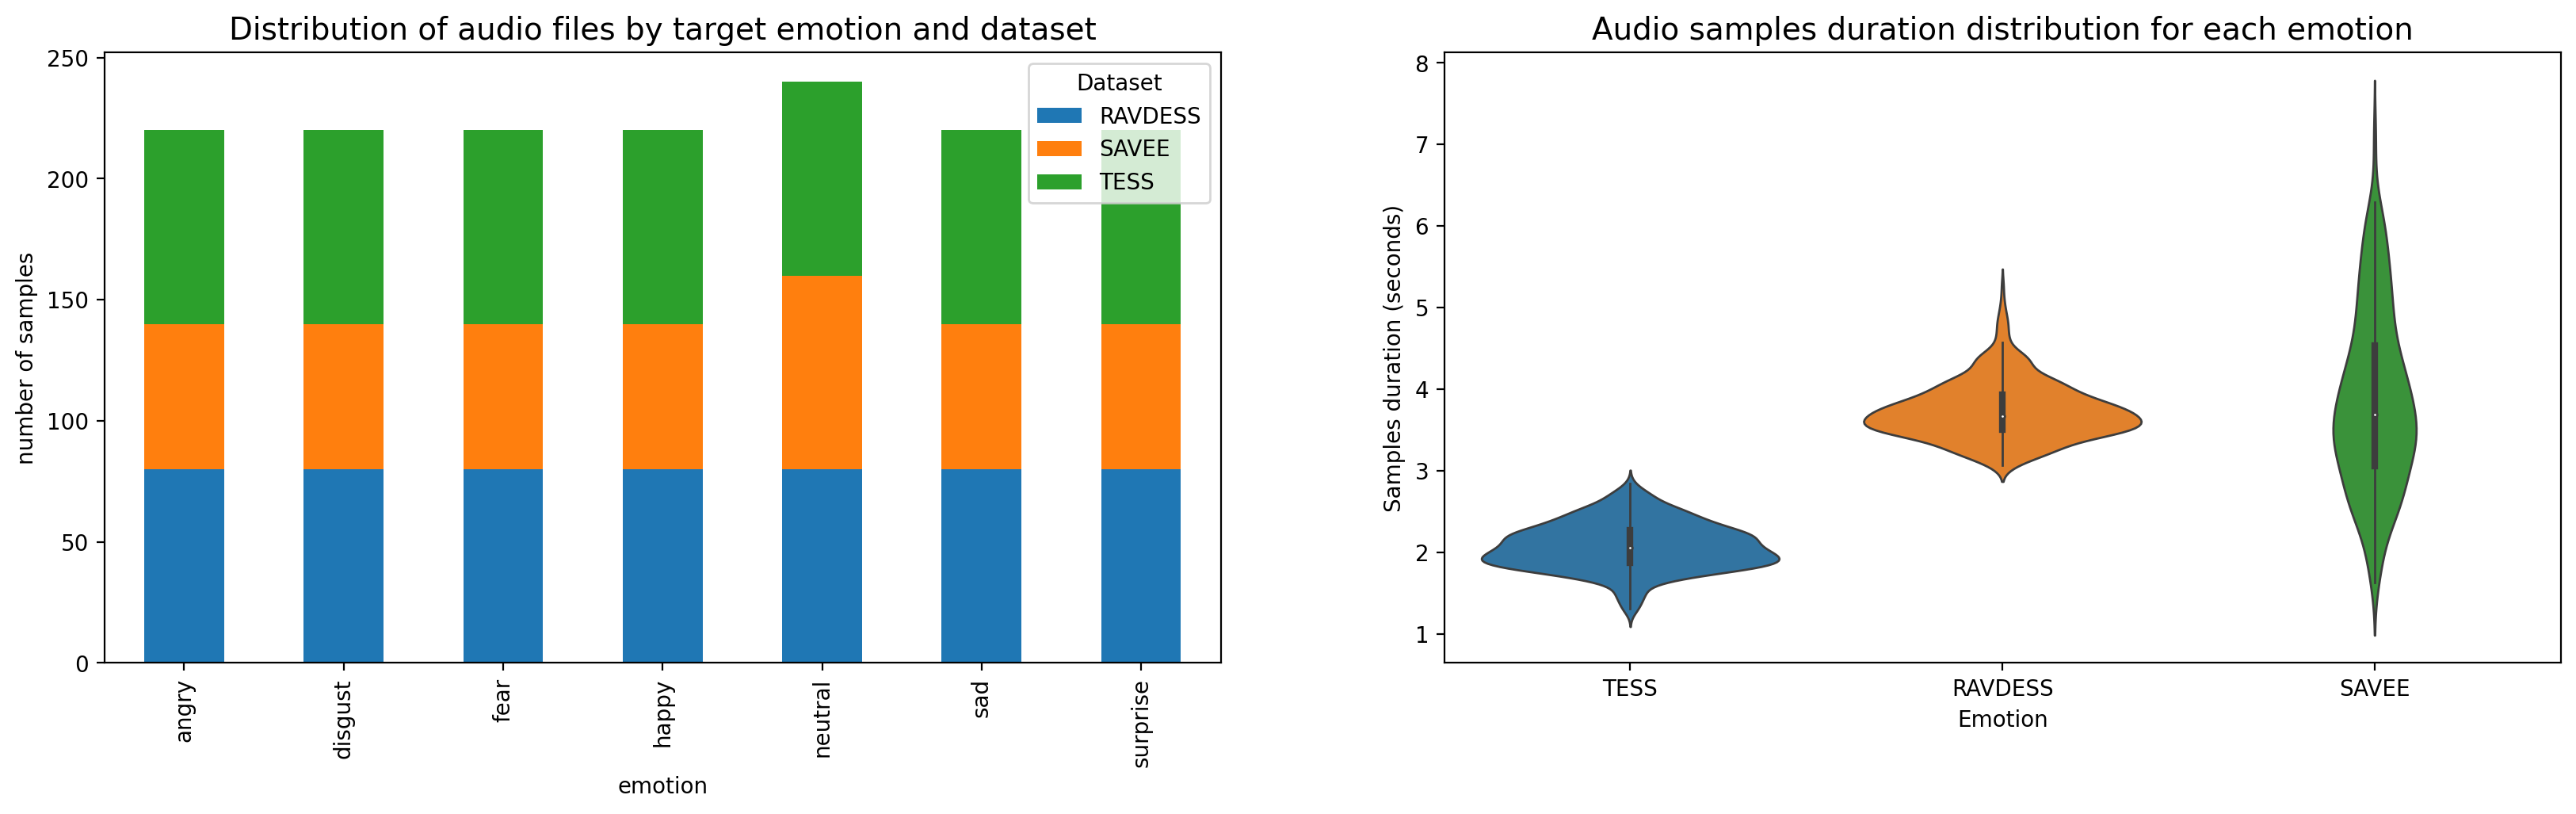

In [38]:
# Figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# Check samples distribution
df.groupby(['emotion','dataset']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Distribution of audio files by target emotion and dataset', size=14)
axes[0].set_ylabel('number of samples')
axes[0].legend(title='Dataset')

# Check duration distribution by each source using violin plots
sns.violinplot(x=df['dataset'],y=df['duration'], linewidth=1, ax=axes[1])
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Samples duration (seconds)')
axes[1].set_title('Audio samples duration distribution for each emotion', size=14)

plt.show()

In [39]:
# function to display samples information by emotion
# note that a random samples is generated each time the function is called
# this is on purpose as to check different samples of each emotion every time

def show_audio(emotion):
    # create sublots
    fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(20,4))
    # filter dataframe to emotion)
    df_show = df.loc[df['emotion'] == emotion].reset_index(drop=True)
    index = random.randint(0, df_show.shape[0])

    # load audio file:
    y, sr = librosa.load(df_show.path[index], sr=16000)

    # Show waveform
    librosa.display.waveshow(y, sr=sr, ax=axs[0])
    axs[0].set_title('Waveform')

    # Extract fundamental frequency (f0) using a probabilistic approach
    f0, _, _ = librosa.pyin(y, sr=sr, fmin=50, fmax=1500, frame_length=2048)

    # Establish timepoint of f0 signal
    timepoints = np.linspace(0, df_show.duration[index], num=len(f0), endpoint=False)

    # Compute short-time Fourier Transform
    x_stft = np.abs(librosa.stft(y))

    # Apply logarithmic dB-scale to spectrogram and set maximum to 0 dB
    x_stft = librosa.amplitude_to_db(x_stft, ref=np.max)

    # Plot STFT spectrogram
    librosa.display.specshow(x_stft, sr=sr, x_axis="time", y_axis="log", ax=axs[1])

    # Plot fundamental frequency (f0) in spectrogram plot
    axs[1].plot(timepoints, f0, color="cyan", linewidth=4)
    axs[1].set_title('Spectrogram with fundamental frequency')

    # Extract 'n_mfcc' numbers of MFCCs components - in this case 30
    x_mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)

    # Plot MFCCs
    librosa.display.specshow(x_mfccs, sr=sr, x_axis="time", norm=Normalize(vmin=-50, vmax=50), ax=axs[2])
    axs[2].set_title('MFCCs')

    # Show metadata in title
    plt.suptitle('File: {}  -  Emotion: {}'.format(df_show.path[index], df_show.emotion[index]), size=14)
    plt.tight_layout()
    plt.show()

    # Display media player for the selected file
    display(ipd.Audio(y, rate=sr))

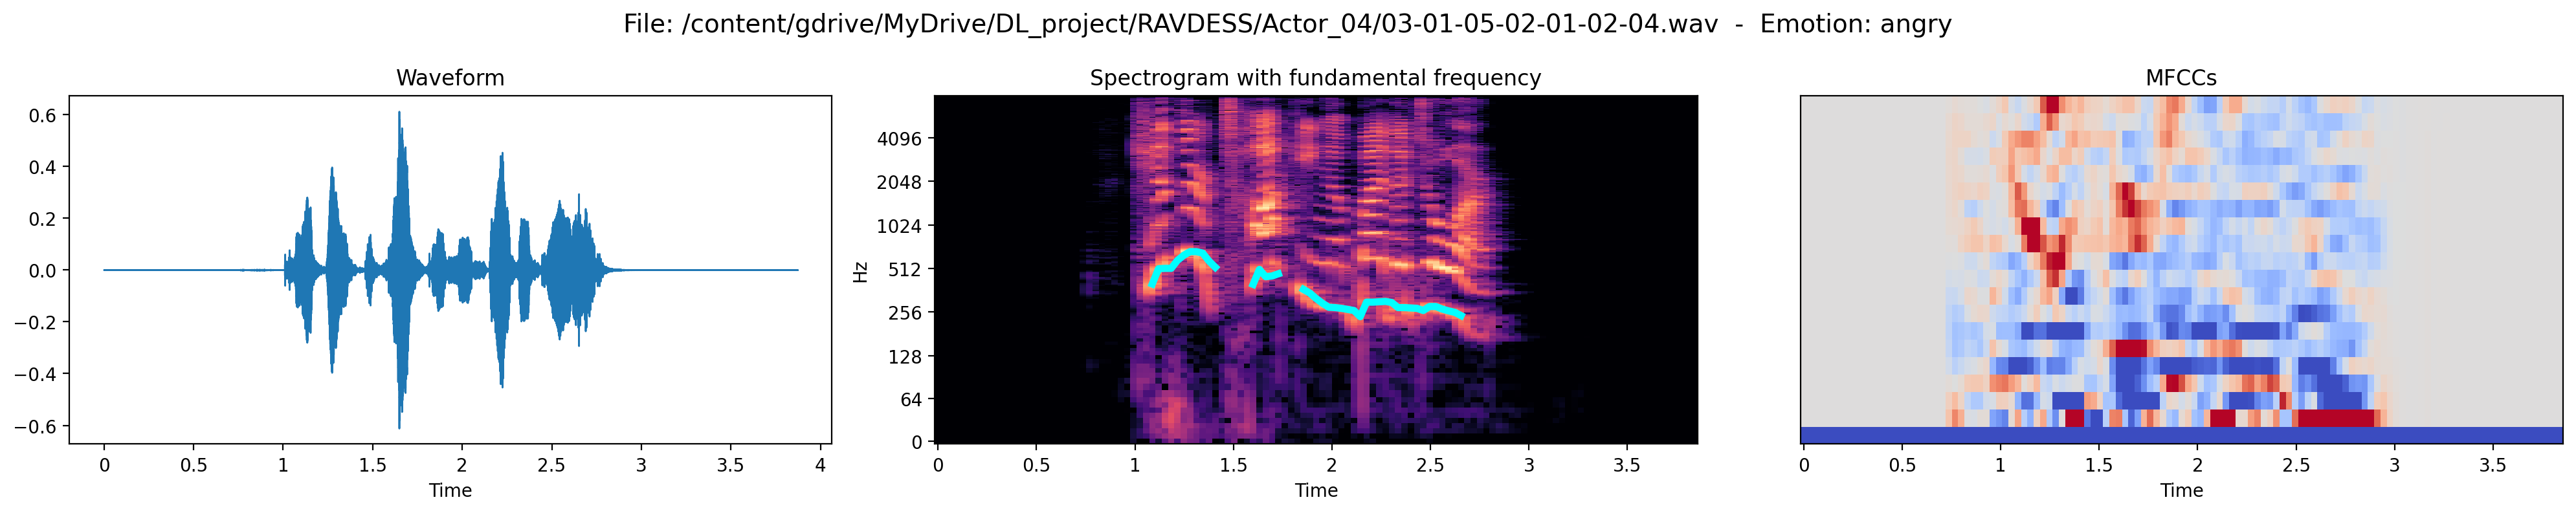

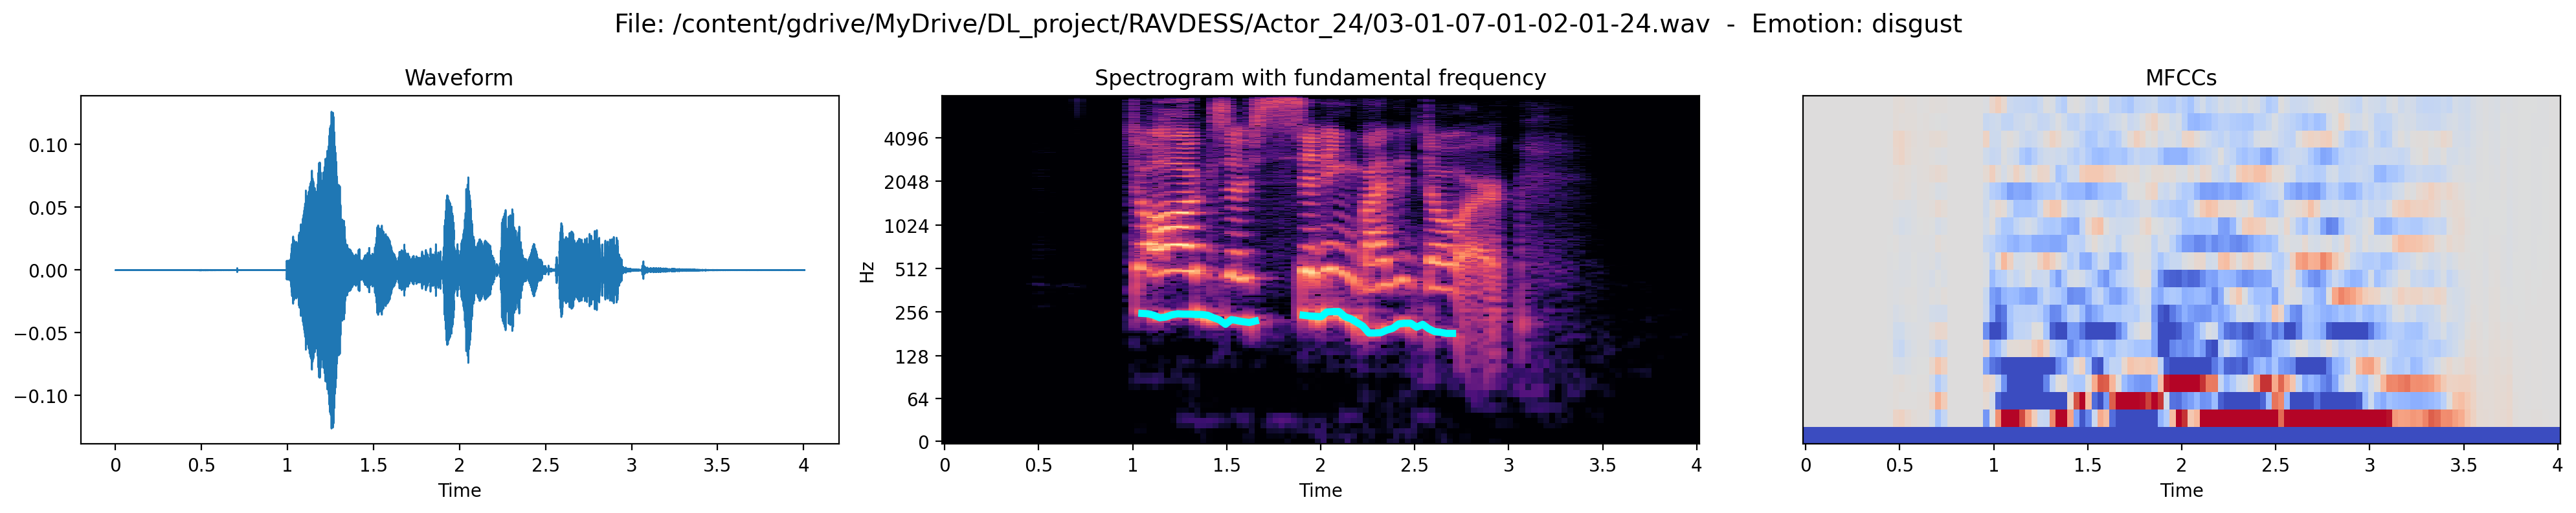

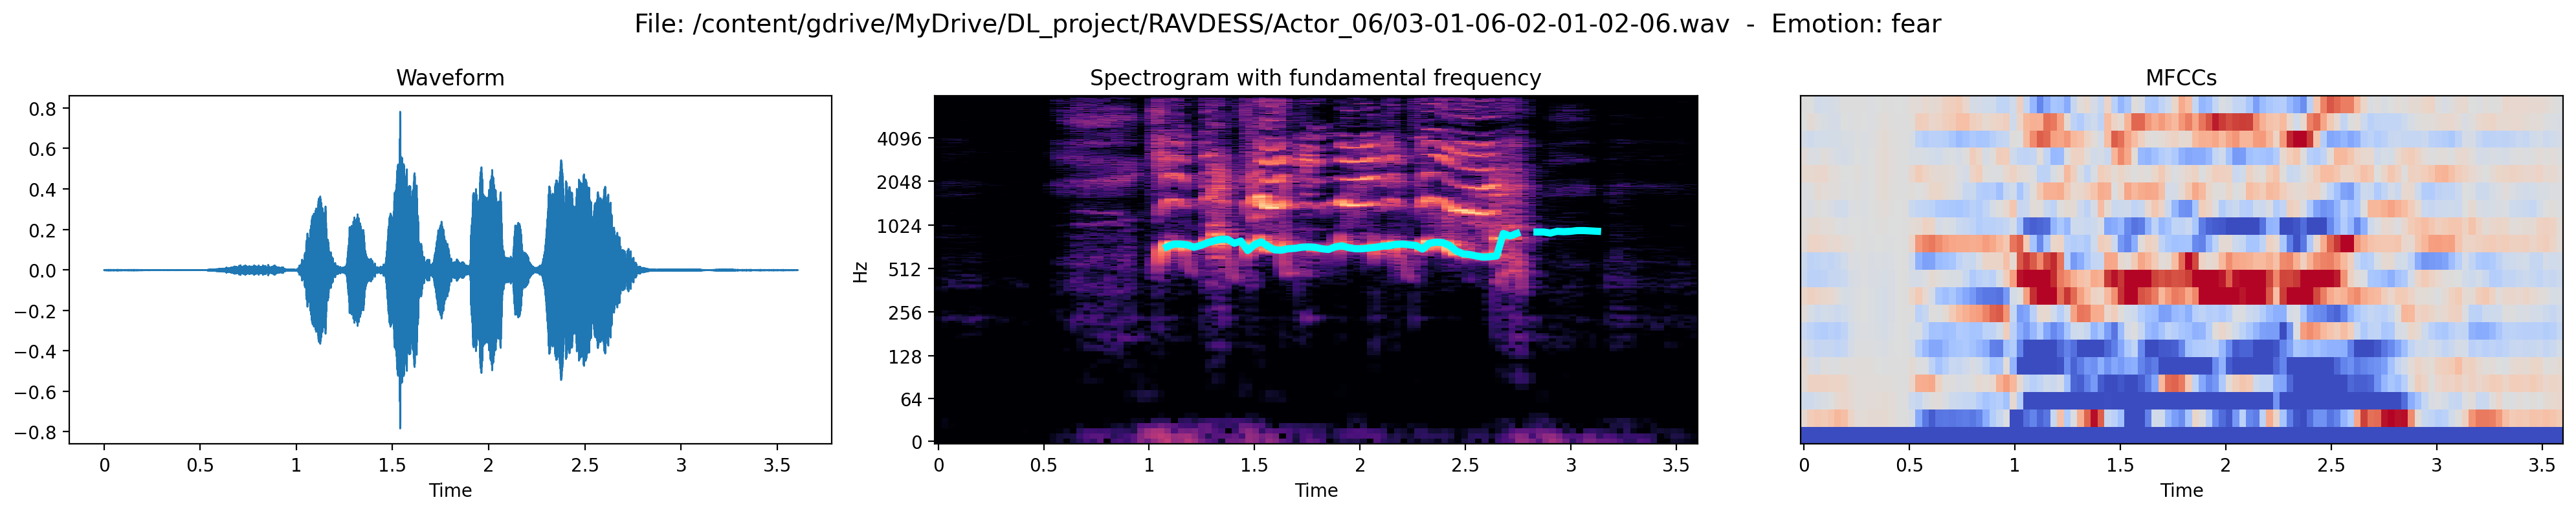

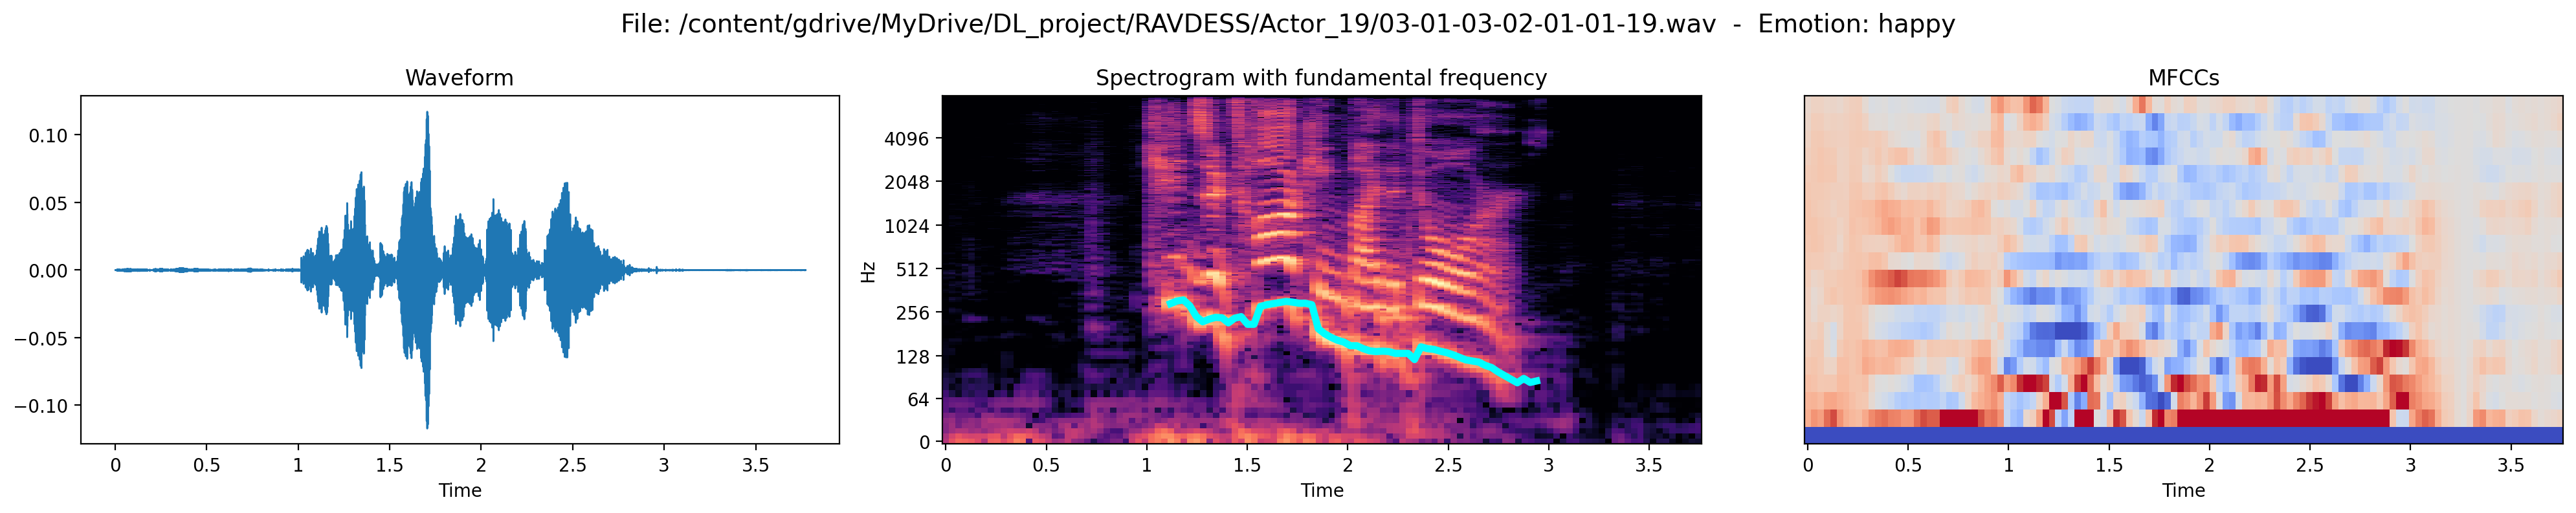

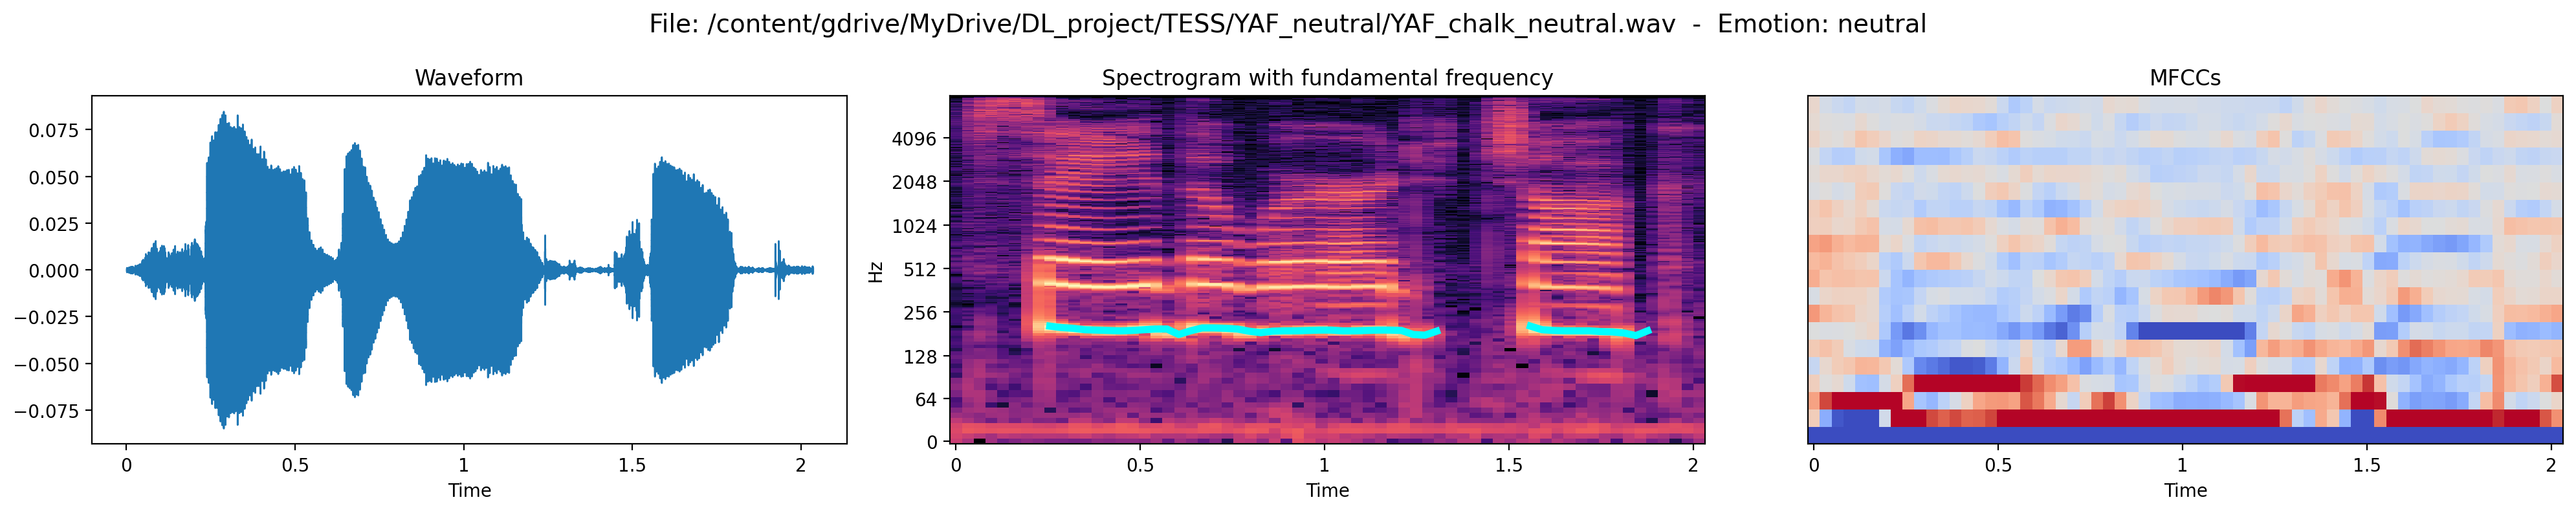

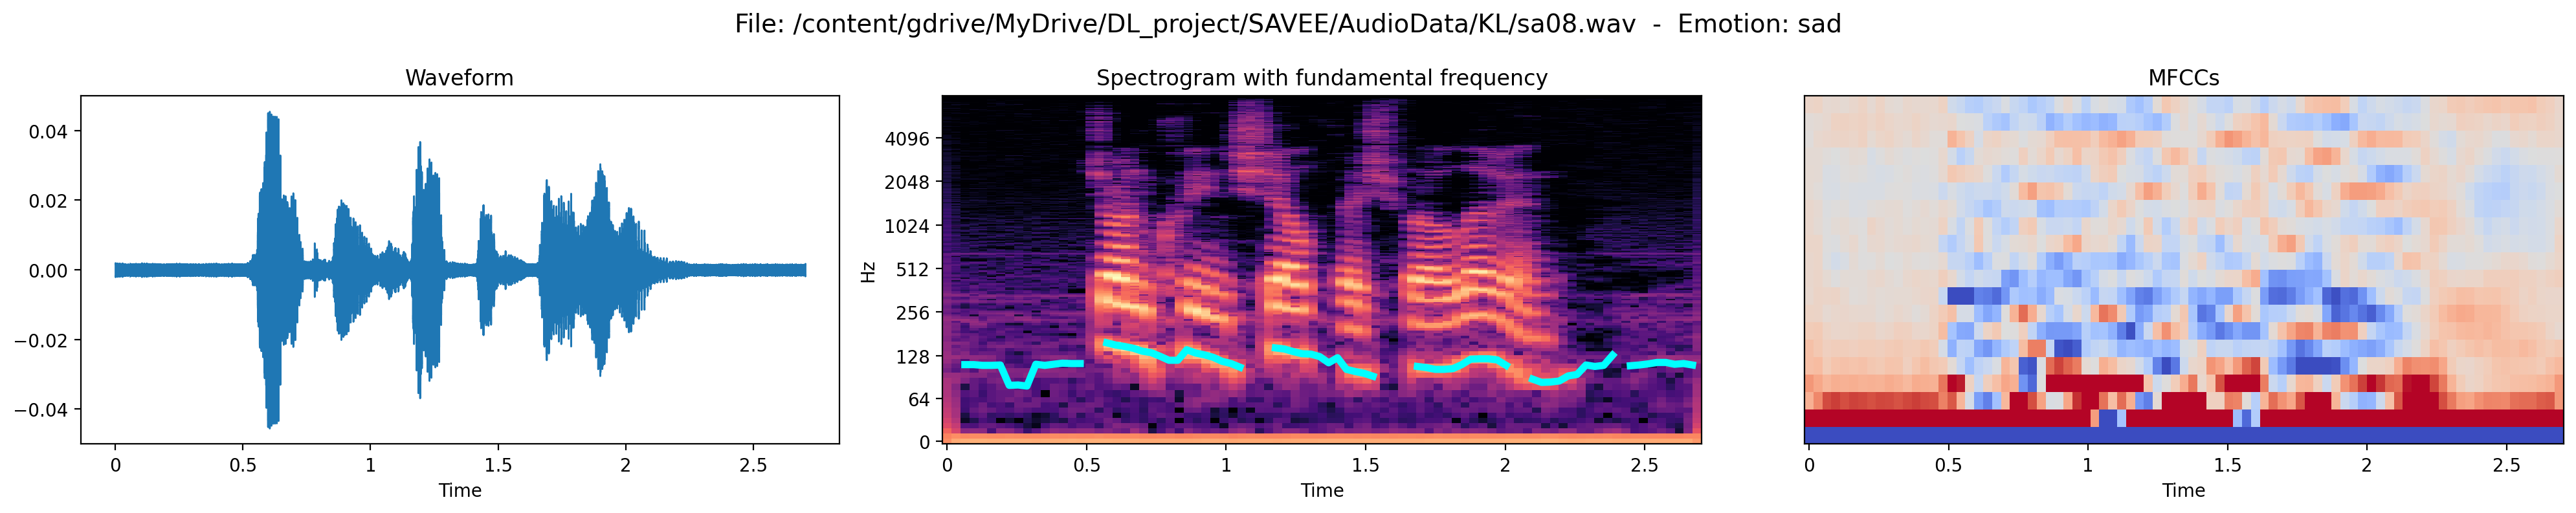

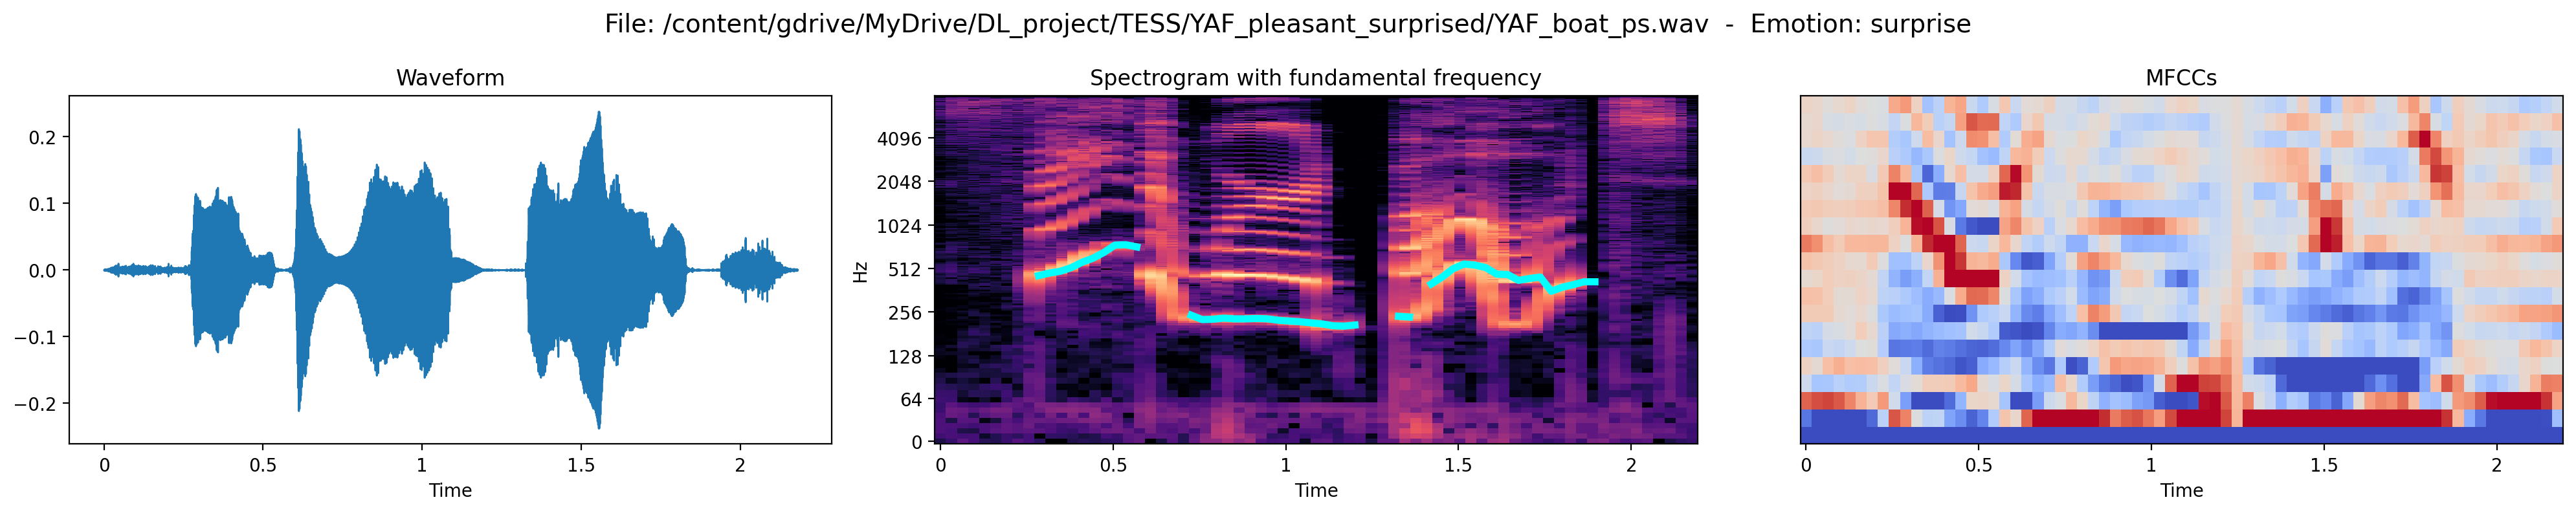

In [40]:
# Getting ordered list of emotions ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emotions = sorted(list(df.emotion.unique()))

# Get waveforms, spectograms, mfccs and media player for each emotion
for emotion in emotions:
    show_audio(emotion)

# 5. Processing Mel-Spectograms

In [ ]:
# create spectrogram list
hopLength = 512
spectrograms = []
i = 0
for file in df.path:

  y, sr = librosa.load(file, sr=16000)

  spectrogram = librosa.power_to_db(librosa.feature.melspectrogram(y = y, sr = sr, n_fft = 2048, hop_length = hopLength, n_mels = 128, power = 4.0), ref = np.max)
  spectrograms.append(spectrogram)
  i = i + 1
  if i % 10 == 0:
    print(i)

In [43]:
print(len(spectrograms))

1560


In [ ]:
# Create a variable to store the new resized mfccs and apply function for all the extracted mfccs
resized_spec = []

new_num_mels = 288
new_num_frames = 432
i = 0

for spectrogram in spectrograms:
  output = zoom(spectrogram, (new_num_mels /spectrogram.shape[0], new_num_frames / spectrogram.shape[1]))
  resized_spec.append(output)
  i = i + 1
  if i % 10 == 0:
    print(i)

In [45]:
print(len(resized_spec))

1560


In [46]:
print(resized_spec[9])

[[-80.       -80.01605  -80.003365 ... -74.70121  -76.456436 -77.114746]
 [-80.       -80.01081  -80.002266 ... -74.60604  -76.10907  -76.66928 ]
 [-80.       -80.00175  -80.00036  ... -73.57125  -74.691925 -75.104774]
 ...
 [-80.       -79.97462  -79.91986  ... -80.       -80.       -80.      ]
 [-80.       -79.989746 -79.96762  ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]]


In [47]:
resized_spec[0].shape

(288, 432)

In [48]:
i = 0
for i in range(len(resized_spec)):
  resized_spec[i] = cv2.cvtColor(resized_spec[i],cv2.COLOR_GRAY2RGB)

In [49]:
print(resized_spec[0].shape)

(288, 432, 3)


# 6. Training Model

In [50]:
# Select target
df['emotion'].replace({'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}, inplace=True)
y = df.emotion.values

# Features
X = resized_spec.copy()

# Create train, validation and test set
x_tr, x_te, y_tr, y_te = train_test_split(X, y, train_size=0.9, shuffle=True, random_state=0)
x_tr, x_va, y_tr, y_va = train_test_split(x_tr, y_tr, test_size=0.3, shuffle=True, random_state=0)

# Convert data to numpy arrays
x_tr = np.array([i for i in x_tr])
x_va = np.array([i for i in x_va])
x_te = np.array([i for i in x_te])

# Plot size of data
print(x_tr.shape)
print(x_va.shape)
print(x_te.shape)

(982, 288, 432, 3)
(422, 288, 432, 3)
(156, 288, 432, 3)


In [53]:
# Get mean and standard deviation from the training set
tr_mean = np.mean(x_tr, axis=0)
tr_std = np.std(x_tr, axis=0)

# Apply data scaling
x_tr = (x_tr - tr_mean)/tr_std
x_va = (x_va - tr_mean)/tr_std
x_te = (x_te - tr_mean)/tr_std

In [54]:
print(f"Dimension of x_tr: {x_tr.shape}.")
print(f"Dimension of x_va: {x_va.shape}.")
print(f"Dimension of x_te: {x_te.shape}.")

Dimension of x_tr: (982, 288, 432, 3).
Dimension of x_va: (422, 288, 432, 3).
Dimension of x_te: (156, 288, 432, 3).


In [55]:
# Compile the model using Adam's default learning rate
newModel.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Create 'EarlyStopping' callback
earlystopping_cb = keras.callbacks.EarlyStopping(patience=3)

In [56]:
#  Train the neural network
history = newModel.fit(
    x=x_tr,
    y=y_tr,
    epochs=100,
    batch_size=32,
    validation_data=(x_va, y_va),
    callbacks=[earlystopping_cb]
)

Epoch 1/100
31/31 [==============================] - 20s 208ms/step - loss: 2.1164 - accuracy: 0.1497 - val_loss: 2.2370 - val_accuracy: 0.2322
Epoch 2/100
31/31 [==============================] - 3s 94ms/step - loss: 2.0174 - accuracy: 0.1497 - val_loss: 2.2246 - val_accuracy: 0.3223
Epoch 3/100
31/31 [==============================] - 2s 74ms/step - loss: 1.9387 - accuracy: 0.1986 - val_loss: 2.1861 - val_accuracy: 0.3436
Epoch 4/100
31/31 [==============================] - 2s 77ms/step - loss: 1.9067 - accuracy: 0.2026 - val_loss: 2.4253 - val_accuracy: 0.3578
Epoch 5/100
31/31 [==============================] - 3s 88ms/step - loss: 1.8464 - accuracy: 0.2627 - val_loss: 2.0850 - val_accuracy: 0.3863
Epoch 6/100
31/31 [==============================] - 3s 88ms/step - loss: 1.8323 - accuracy: 0.2597 - val_loss: 2.2752 - val_accuracy: 0.3863
Epoch 7/100
31/31 [==============================] - 3s 100ms/step - loss: 1.8626 - accuracy: 0.2546 - val_loss: 2.0034 - val_accuracy: 0.3697
Epo

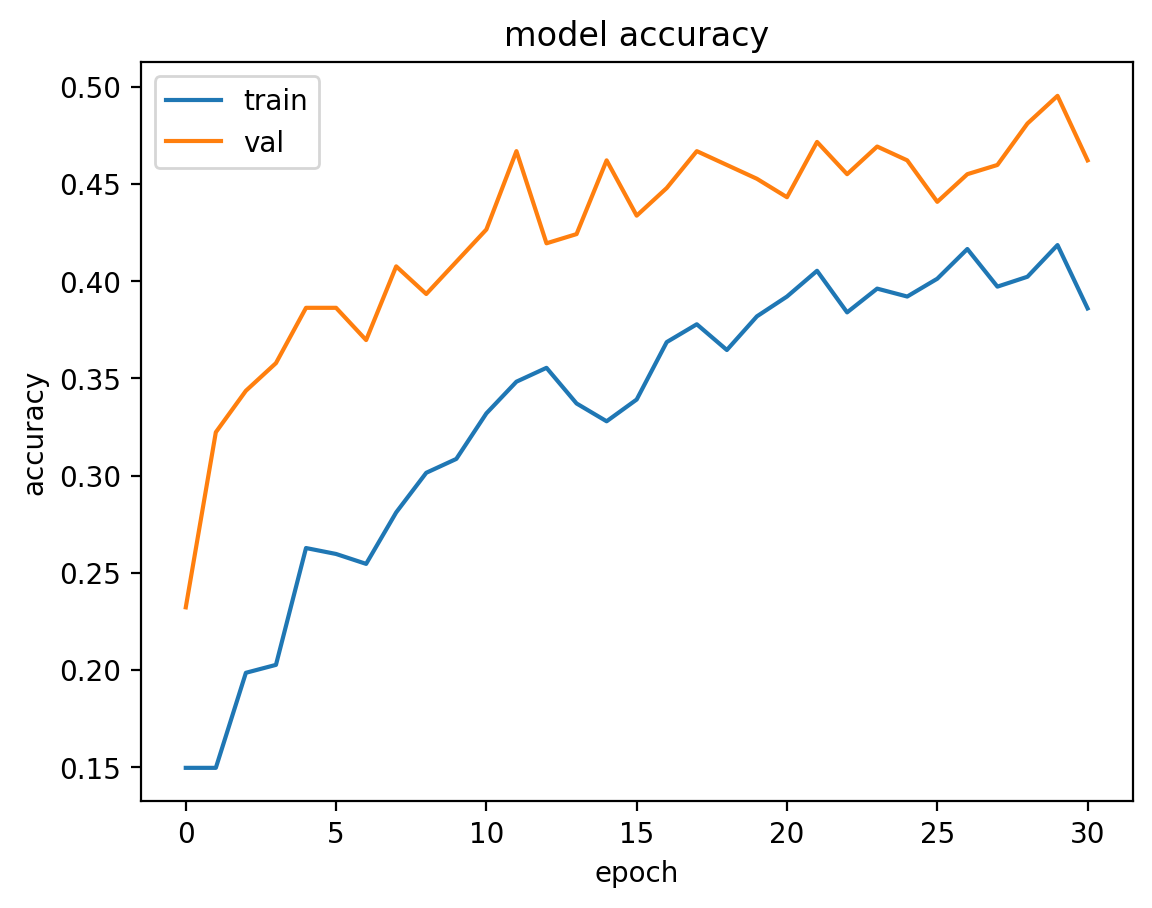

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

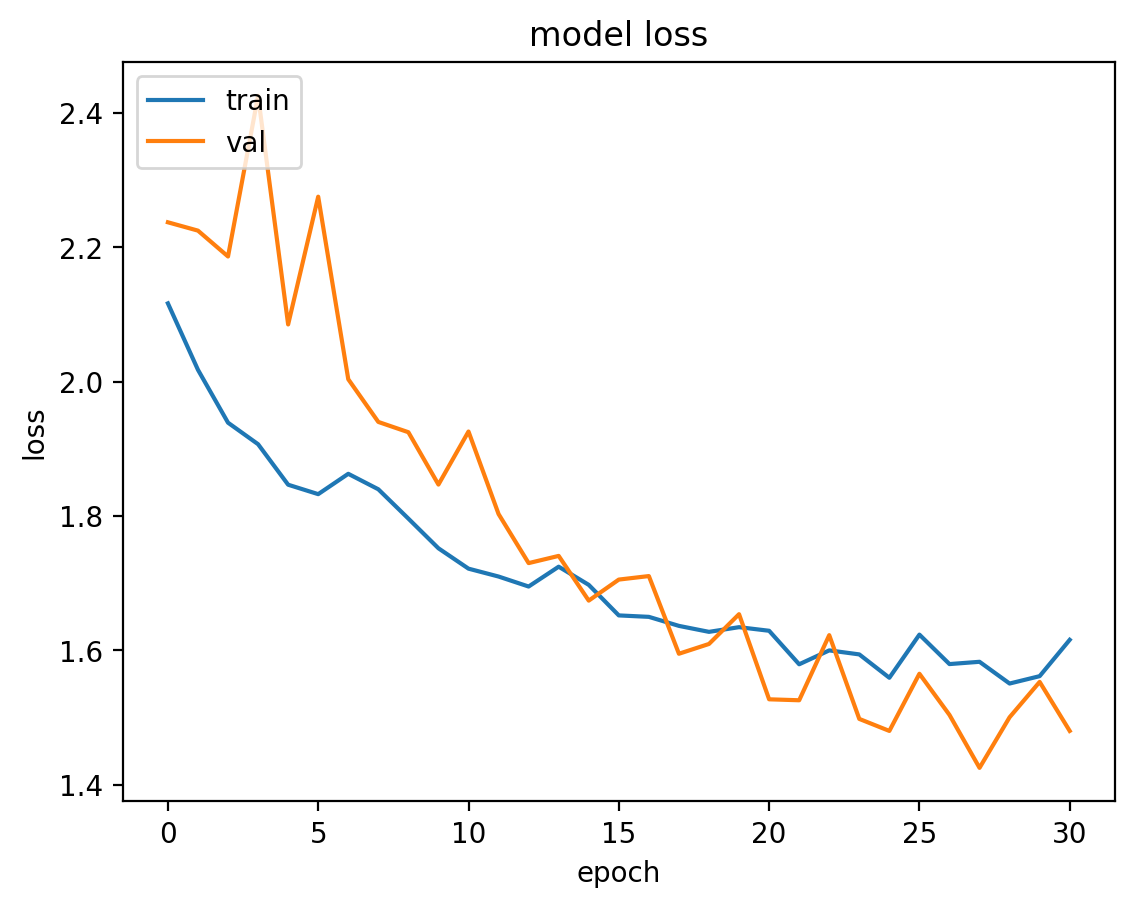

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 7. Test Data Report and Confusion Matrix

In [61]:
# predict the probability distribution of the data
# predictions=newModel.predict(x_te, steps=28, verbose=1)
pred = newModel.predict(x_te)
y_pred = np.argmax(pred, axis=-1)

# get the classification report
print(classification_report(y_te, y_pred))

5/5 [==============================] - 0s 61ms/step
              precision    recall  f1-score   support

           0       1.00      0.33      0.50        24
           1       0.83      0.38      0.53        26
           2       0.57      0.44      0.50        18
           3       0.91      0.43      0.59        23
           4       0.25      0.80      0.38        20
           5       0.36      0.50      0.42        24
           6       0.57      0.38      0.46        21

    accuracy                           0.46       156
   macro avg       0.64      0.47      0.48       156
weighted avg       0.66      0.46      0.48       156



Text(0.5, 23.52222222222222, 'Predicted label')

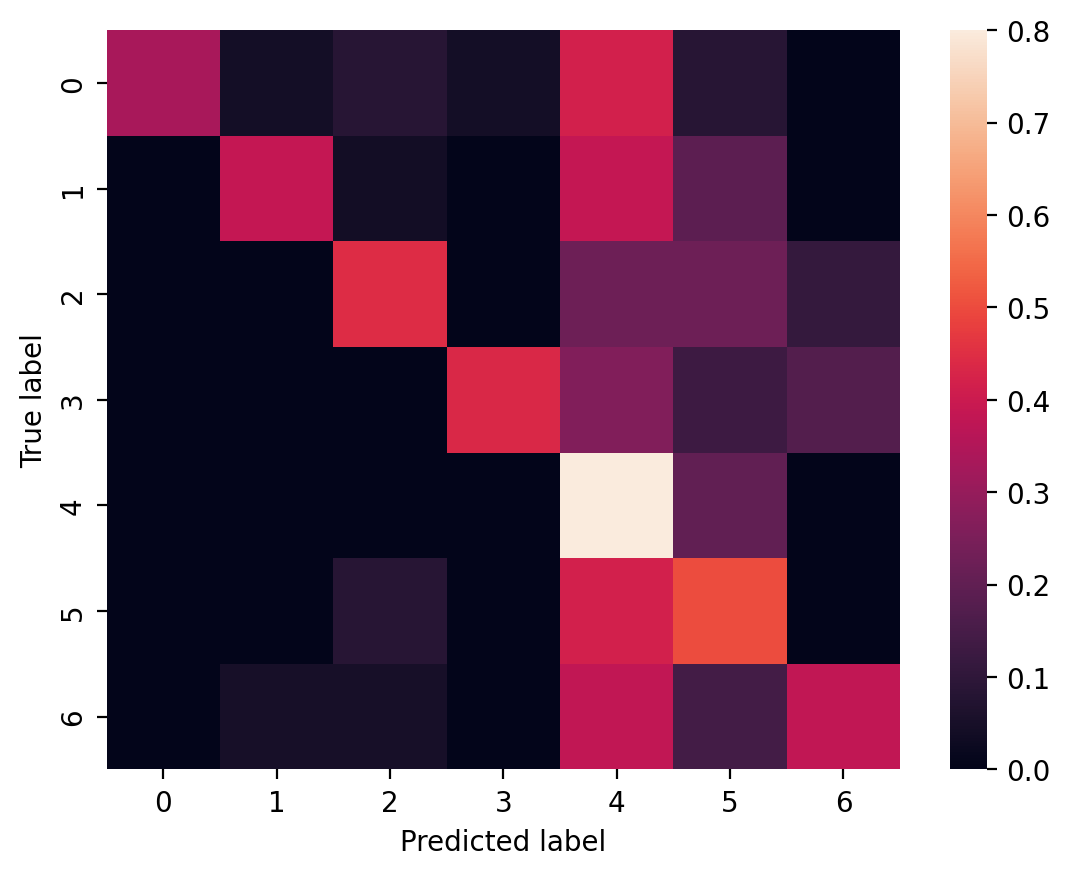

In [62]:
conf_mat = confusion_matrix(y_te, y_pred)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Conclusion

The accuracy of 46% tells us that both speech and music possess varying acoustic characteristics. Thus, we have successfully disproved our earlier hypothesis while simultaneously obtaining satisfactory accuracy for the music genre classificaiton task (73%)